In [17]:
import numpy as np
import tensorflow as tf
import cv2
import time
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from planet import planet
from bssfp_data_generator.planet2 import planet

In [18]:
# Load bSSFP images training data and ground truth 
img_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\img_data.npy')
gt_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\gt_img_data.npy')
gt_check = gt_data[0]

img_data = (img_data - np.min(img_data))/(np.max(img_data) - np.min(img_data))

# Train test split
img_train, img_test, gt_train, gt_test = train_test_split(img_data, gt_data, test_size=0.1, random_state=42)

(-0.5, 167.5, 39.5, -0.5)

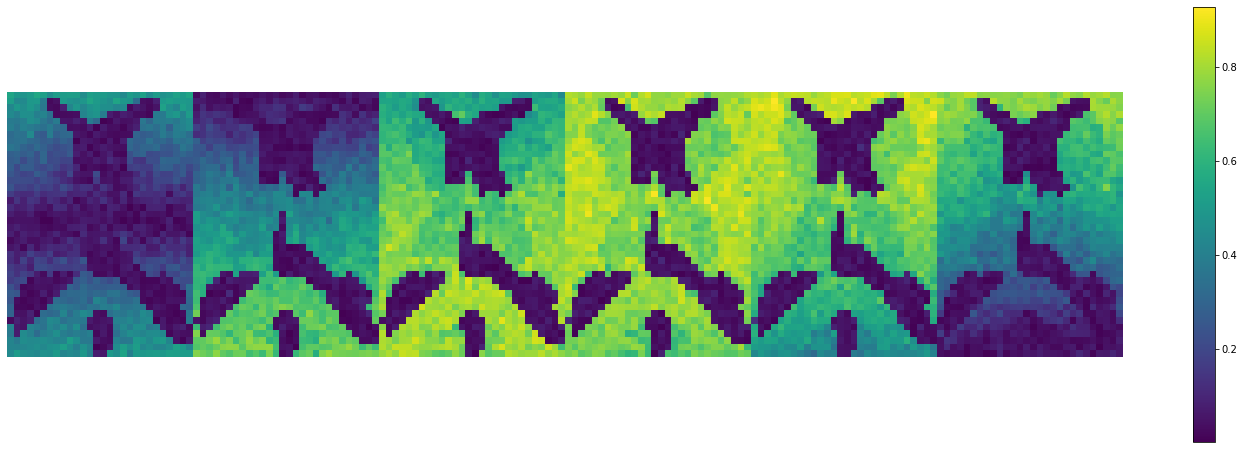

In [19]:
test_data = img_train[2]
plt.figure(figsize=(25,8))
im = plt.imshow(img_train[2])
plt.colorbar(im)
# plt.imshow(img_train[2],cmap='gray') # greyscale
plt.axis('off')

(-0.5, 27.5, 39.5, -0.5)

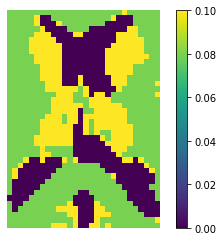

In [20]:
im = plt.imshow(gt_train[0])
plt.colorbar(im)
plt.axis('off')
# Gray Matter  (100ms)  in yellow
# White Matter (80ms) in green

In [11]:
def Model():

    def down_block(x, filters):
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x

    def max_pool(x):
        return tf.keras.layers.MaxPooling1D(padding="same", strides=2, pool_size=2)(x)

    def up_block(x, filters, skip_connect):
        # x = UpSampling1D(size = 2)(x)
        x = tf.keras.layers.Conv1DTranspose(filters, 3, strides=2, padding="same", activation=tf.nn.relu)(x)
        x = tf.keras.layers.concatenate([x, skip_connect], axis=2)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = tf.keras.layers.Dropout(rate=0.0)(x)
        return x 

    def unet():
        fn = [42, 84, 168, 336]
        fdepth = len(fn)

        x_stack = []
        xin = tf.keras.Input(shape=(img_data.shape[1],img_data.shape[2]), name='img')

        x = xin
        for idx in range(fdepth):
            x = down_block(x, fn[idx])

            if(idx < fdepth - 1):
                x_stack.append(x)
                x = max_pool(x)

        for idx in range(fdepth - 1):
            idx = fdepth - idx - 2
            x = up_block(x, fn[idx], x_stack.pop())

        xout = tf.keras.layers.Conv1D(gt_data.shape[2], 1, padding="same", activation='linear')(x)
        return tf.keras.Model(inputs=xin, outputs=xout)

    return unet()

In [21]:
# Setup Unet model
model = Model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 40, 168)]    0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 40, 42)       21210       img[0][0]                        
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 40, 42)       5334        conv1d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 40, 42)       168         conv1d_16[0][0]                  
_______________________________________________________________________________________

In [22]:
# Define optimizer and train the network
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics='mse')
start=time.time()

# Starts training
history = model.fit(img_train, gt_train, epochs=30, batch_size=10, validation_split=0.1)  
end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/30
81/81 [==============================] - 5s 59ms/step - loss: 0.1813 - mse: 0.1813 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 2/30
81/81 [==============================] - 4s 46ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/30
81/81 [==============================] - 3s 43ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/30
81/81 [==============================] - 3s 42ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/30
81/81 [==============================] - 3s 42ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/30
81/81 [==============================] - 3s 43ms/step - loss: 8.4338e-04 - mse: 8.4338e-04 - val_loss: 8.3384e-04 - val_mse: 8.3384e-04
Epoch 7/30
81/81 [==============================] - 3s 42ms/step - loss: 6.7668e-04 - mse: 6.7668e-04 - val_loss: 6.7654e-04 - val_mse: 6.7654e-04
Epoch 8/30
81/81 [==============================] -

In [23]:
# Save or load trained model 
model.save('image_regression'); 
#model = tf.keras.models.load_model('image_regression')

INFO:tensorflow:Assets written to: image_regression\assets


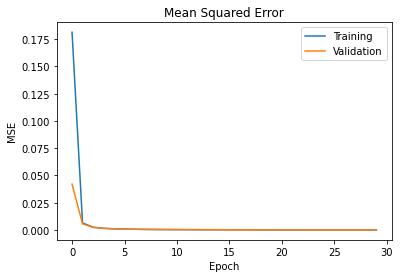

10/10 [==============================] - 0s 14ms/step - loss: 9.0515e-05 - mse: 9.0515e-05
Test MSE:0.000091


In [24]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(img_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

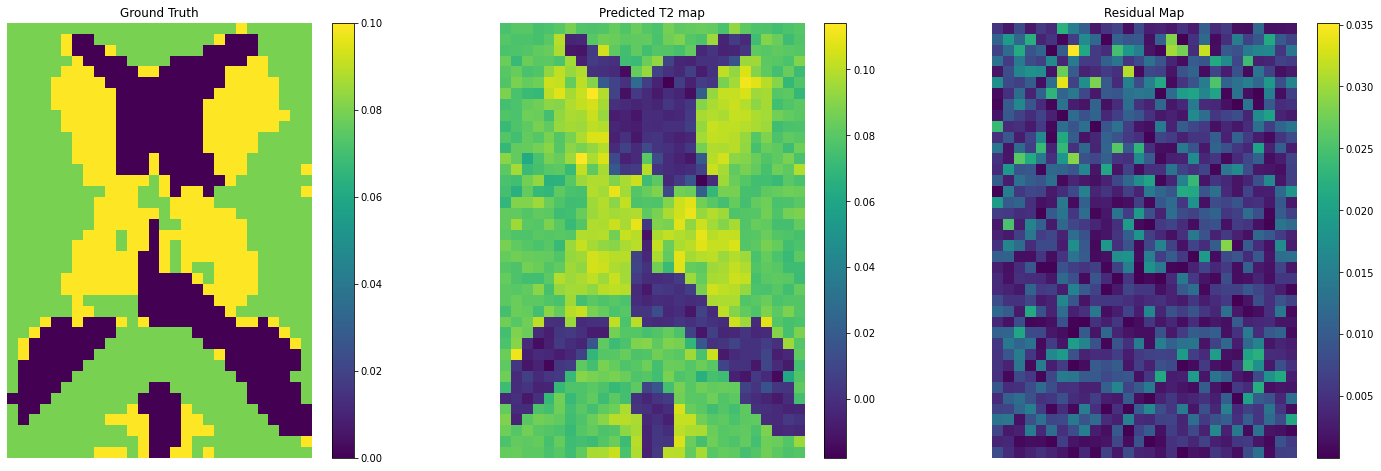

In [25]:
predicted_t2map = model.predict(img_test)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
im = ax1.imshow(gt_test[0])
ax1.axis('off')
ax1.set_title('Ground Truth')
plt.colorbar(im,ax=ax1)

im = ax2.imshow(predicted_t2map.mean(axis=0))
ax2.axis('off')
ax2.set_title('Predicted T2 map')
plt.colorbar(im,ax=ax2)

residual_map = abs(gt_test[0]-predicted_t2map[0])
im = ax3.imshow(residual_map)
ax3.axis('off')
ax3.set_title('Residual Map')
plt.colorbar(im,ax=ax3)